# Case Datarisk - Detecção de Fraudes

Foram fornecidas os arquivos base_info.csv, base_cadastral.csv e base_pagamentos.csv.
- base_cadastral possui informações fixas (cadastrais) sobre cada cliente.
- base_info possui informações mensais de renda e número de empregados.
- base_pagamentos possui informações referentes a cada operação de crédito.

## Preprocessamento e Visualização dos Dados
- leitura dos arquivos e ajuste de cada tipo de dado.
- codificação (one_hot, categorica e ordinal) dos dados cadastrais.
- visualização dos dados do cliente reduzido para 3 dimensões.

In [1]:
## Leitura dos arquivos e ajuste de cada tipo de dado.

import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot  as plt
import seaborn as sns

# Load the data from the CSV files
base_info = pd.read_csv('base_info.csv')
base_pagamentos = pd.read_csv('base_pagamentos_desenvolvimento.csv')
base_pagamentos_teste = pd.read_csv('base_pagamentos_teste.csv')
base_cadastral = pd.read_csv('base_cadastral.csv')

# lower case all column names
base_info.columns = base_info.columns.str.lower()
base_pagamentos.columns = base_pagamentos.columns.str.lower()
base_pagamentos_teste.columns = base_pagamentos_teste.columns.str.lower()
base_cadastral.columns = base_cadastral.columns.str.lower()

# give a new id to each client based on registrartion date order
base_cadastral = base_cadastral.sort_values('data_cadastro').reset_index(drop=True)
base_cadastral['new_id'] = range(1, len(base_cadastral) + 1)

# save a corresponding dictionary of old_id and new_id
id_dict = base_cadastral[['id_cliente', 'new_id']].set_index('id_cliente').to_dict()

# convert str to date
def convert_date(df, to_date_columns, format):
  df_copy = df.copy()
  for col in to_date_columns:
    df_copy[col] = pd.to_datetime(df_copy[col], format=format)#.dt.date
  return df_copy

date_columns = ['data_emissao_documento', 'data_pagamento', 'data_vencimento']
base_pagamentos_date = convert_date(base_pagamentos, date_columns, '%Y-%m-%d')
base_pagamentos_date = convert_date(base_pagamentos_date, ['safra_ref'], '%Y-%m')
base_info_date = convert_date(base_info, ['safra_ref'], '%Y-%m')
base_cadastral_date = convert_date(base_cadastral, ['data_cadastro'], '%Y-%m-%d')
date_columns = ['data_emissao_documento', 'data_vencimento']
base_pagamentos_teste_date = convert_date(base_pagamentos_teste, date_columns, '%Y-%m-%d')
base_pagamentos_teste_date = convert_date(base_pagamentos_teste_date, ['safra_ref'], '%Y-%m')

# ajust values in base_cadastral
base_cadastral_date.flag_pf = (base_cadastral_date.flag_pf == 'X').astype(int)
base_cadastral_date.segmento_industrial = base_cadastral_date.segmento_industrial.fillna('NAN')
base_cadastral_date.dominio_email = base_cadastral_date.dominio_email.fillna('NAN')
base_cadastral_date.porte = base_cadastral_date.porte.fillna('NAN')
base_cadastral_date.cep_2_dig = base_cadastral_date.cep_2_dig.fillna('NA')
base_cadastral_date.ddd = base_cadastral_date.ddd.fillna('-1')
base_cadastral_date.loc[base_cadastral_date['ddd'].str.contains("\("), 'ddd'] = '-2'

# Add a binary column, fraud, to base_pagamentos_desenvolvimento_coherent and assing 1 to rows where DATA_PAGAMENTO > DATA_VENCIMENTO + 5
base_pagamentos_date['late_payment'] = (base_pagamentos_date['data_pagamento'] - base_pagamentos_date['data_vencimento']).dt.days
base_pagamentos_date['fraud'] = np.where(base_pagamentos_date['late_payment'] > 5, 1, 0)

In [2]:
## codificação (one_hot, categorica e ordinal) dos dados da base cadastral

# date encoding
def encode_date(df, columns):
    df_copy = df.copy()
    for col in columns:
        min_date = df_copy[col].min()
        df_copy[col + '_since_min'] = (df_copy[col] - min_date).dt.days + 1
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

# One-hot encoding for categorical variables
def encode_categorical(df, columns):
    df_copy = df.copy()
    for col in columns:
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[col], prefix=col)], axis=1)
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

# ordinal encoding for categorical variables
def encode_ordinal(df, columns, mapping):
    df_copy = df.copy()
    for i, col in enumerate(columns):
        df_copy[col + '_encoded'] = df_copy[col].map(mapping[i])
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

ordinal_encode_map = [{'NAN': 0, 'PEQUENO': 1, 'MEDIO': 2, 'GRANDE': 3}]
base_cadastral_date_encoded = encode_date(base_cadastral_date, ['data_cadastro'])
base_cadastral_one_hot_encoded = encode_categorical(base_cadastral_date_encoded, ['segmento_industrial', 'dominio_email'])
base_cadastral_ordinal_encoded = encode_ordinal(base_cadastral_one_hot_encoded, ['porte'], ordinal_encode_map)
base_cadastral_droped = base_cadastral_ordinal_encoded.drop(['id_cliente', 'ddd', 'cep_2_dig'], axis=1)
base_cadastral_droped

# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
base_cadastral_scaled = scaler.fit_transform(base_cadastral_droped)
base_cadastral_scaled = pd.DataFrame(base_cadastral_scaled, columns=base_cadastral_droped.columns)
# display(base_cadastral_scaled.head())

In [ ]:
# visualização dos dados do cliente reduzido para 3 dimensões

from sklearn.manifold import TSNE
base_cadastral_tsne = TSNE(n_components=3).fit_transform(base_cadastral_scaled)
print(base_cadastral_tsne.shape)

# plot 16 TSNEs with different columns as color
fig = plt.figure(figsize=(20, 20))
for i, col in enumerate(base_cadastral_scaled.columns):
    ax = fig.add_subplot(4, 4, i+1, projection='3d')
    ax.scatter(base_cadastral_tsne[:, 0], 
               base_cadastral_tsne[:, 1], 
               base_cadastral_tsne[:, 2], 
               c=base_cadastral_scaled[col], 
               cmap='coolwarm')
    plt.title(col)
plt.show()

base_cadastral_tsne_df = pd.DataFrame(base_cadastral_tsne, columns=['tsne_1', 'tsne_2', 'tsne_3'])

## Codificação (compressão) da informação de cada cliente na base cadastral
- codificação via modelo autoencoder para redução de dimensionalidade de 15 para 3.
- visualização do treinamento do modelo.
- análise de erro do modelo.
- visualização do cliente em 3 dimensões.

In [3]:
## codificação via modelo autoencoder para redução de dimensionalidade de 15 para 3

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

def create_layers(input_layer, units, activation='relu', dropout_rate=0.1):
    x_dense = Dense(units, activation=activation)(input_layer)
    x_bn = BatchNormalization()(x_dense)
    x_drop = Dropout(dropout_rate)(x_bn)
    return [x_dense, x_bn, x_drop]

def autoencoder_model(input_dim, encoding_dim, learning_rate=0.002, weight_decay=0.0001):
    input_layer = Input(shape=(input_dim, ))

    # encoder
    encoder = create_layers(input_layer, 25)
    encoder = create_layers(encoder[2], 15)
    encoder = create_layers(encoder[2] + input_layer, 15)
    encoder_skip = create_layers(encoder[2], 15)
    encoder = create_layers(encoder_skip[2] + encoder[1], 15)
    encoded = Dense(encoding_dim, activation='linear')(encoder[2])

    # decoder
    decoder = create_layers(encoded, 15)
    decoder_skip = create_layers(decoder[2], 15)
    decoder = create_layers(decoder_skip[2] + decoder[1], 15)
    decoder = create_layers(decoder[2], 15)
    decoder = create_layers(decoder[2], 25)
    decoded = Dense(input_dim, activation='linear')(decoder[2])

    autoencoder = Model(inputs=input_layer, outputs=decoded)

    adam = Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    autoencoder.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

    return autoencoder

input_dim = base_cadastral_scaled.shape[1]
encoding_dim = 3

autoencoder = autoencoder_model(input_dim, encoding_dim)
histories = []
history = autoencoder.fit(base_cadastral_scaled, base_cadastral_scaled, epochs=100, batch_size=64, validation_split=0.2)
histories.append(history)

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-18].output)
encoded_data = encoder.predict(base_cadastral_scaled)


2023-05-23 00:05:44.947840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 00:05:46.589622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 00:05:46.589706: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-23 00:05:48.996933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/100
17/17 [==============================] - 16s 128ms/step - loss: 1.8070 - mae: 0.9856 - val_loss: 1.1666 - val_mae: 0.7652
Epoch 2/100
17/17 [==============================] - 1s 34ms/step - loss: 1.3657 - mae: 0.8607 - val_loss: 1.1748 - val_mae: 0.7678
Epoch 3/100
17/17 [==============================] - 1s 30ms/step - loss: 1.1712 - mae: 0.7937 - val_loss: 1.1781 - val_mae: 0.7633
Epoch 4/100
17/17 [==============================] - 1s 35ms/step - loss: 1.0712 - mae: 0.7486 - val_loss: 1.1734 - val_mae: 0.7565
Epoch 5/100
17/17 [==============================] - 1s 45ms/step - loss: 1.0077 - mae: 0.7211 - val_loss: 1.1534 - val_mae: 0.7526
Epoch 6/100
17/17 [==============================] - 1s 45ms/step - loss: 0.9662 - mae: 0.7028 - val_loss: 1.1230 - val_mae: 0.7443
Epoch 7/100
17/17 [==============================] - 1s 53ms/step - loss: 0.9079 - mae: 0.6763 - val_loss: 1.0867 - val_mae: 0.7348
Epoch 8/100
17/17 [==============================] - 1s 40ms/step - loss: 

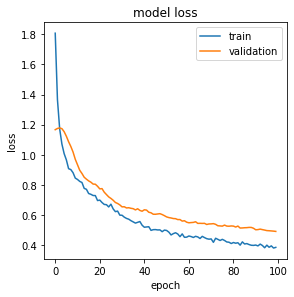

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 25)           400         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25)          100         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 25)           0           ['batch_normalization[0][0]

In [4]:
## visualização do treinamento do modelo

# plot losses
fig = plt.figure(figsize=(20, 20))
for i, history in enumerate(histories):
    ax = fig.add_subplot(4, 4, i+1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
plt.show()

encoder.summary()

42/42 [==============================] - 1s 6ms/step


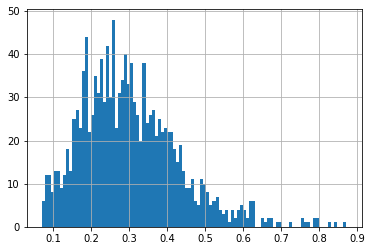

,id_cliente,data_cadastro,flag_pf,dominio_email,porte,new_id
segmento_industrial,,,,,,
Comércio,0.009281,0.009281,0.009281,0.009281,0.009281,0.009281
Indústria,0.023490,0.023490,0.023490,0.023490,0.023490,0.023490
NAN,0.325301,0.325301,0.325301,0.325301,0.325301,0.325301
Serviços,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988


,id_cliente,data_cadastro,flag_pf,segmento_industrial,porte,new_id
dominio_email,,,,,,
AOL,0.054054,0.054054,0.054054,0.054054,0.054054,0.054054
BOL,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
GMAIL,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692
HOTMAIL,0.024768,0.024768,0.024768,0.024768,0.024768,0.024768
NAN,0.233333,0.233333,0.233333,0.233333,0.233333,0.233333
OUTLOOK,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
YAHOO,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857


,id_cliente,data_cadastro,segmento_industrial,dominio_email,porte,new_id
flag_pf,,,,,,
0,0.021617,0.021617,0.021617,0.021617,0.021617,0.021617
1,0.181818,0.181818,0.181818,0.181818,0.181818,0.181818


,id_cliente,data_cadastro,flag_pf,segmento_industrial,dominio_email,new_id
porte,,,,,,
GRANDE,0.039583,0.039583,0.039583,0.039583,0.039583,0.039583
MEDIO,0.015326,0.015326,0.015326,0.015326,0.015326,0.015326
NAN,0.097561,0.097561,0.097561,0.097561,0.097561,0.097561
PEQUENO,0.029412,0.029412,0.029412,0.029412,0.029412,0.029412


In [5]:
## análise de erro do modelo

decoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-1].output)
decoded_data = decoder.predict(base_cadastral_scaled)

decoded_data = pd.DataFrame(decoded_data, columns=base_cadastral_scaled.columns)
decoded_data['error'] = np.reshape(np.mean(np.abs(base_cadastral_scaled.values - decoded_data.values), axis=1), (-1, 1))

decoded_data['error'].hist(bins=100)
plt.show()

col = 'segmento_industrial'
base_cadastral_raw_drop = base_cadastral_date.drop(['ddd', 'cep_2_dig'], axis=1)
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('segmento_industrial').count() / base_cadastral_raw_drop.groupby('segmento_industrial').count())
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('dominio_email').count() / base_cadastral_raw_drop.groupby('dominio_email').count())
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('flag_pf').count() / base_cadastral_raw_drop.groupby('flag_pf').count())
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('porte').count() / base_cadastral_raw_drop.groupby('porte').count())

All encoded representations are unique.


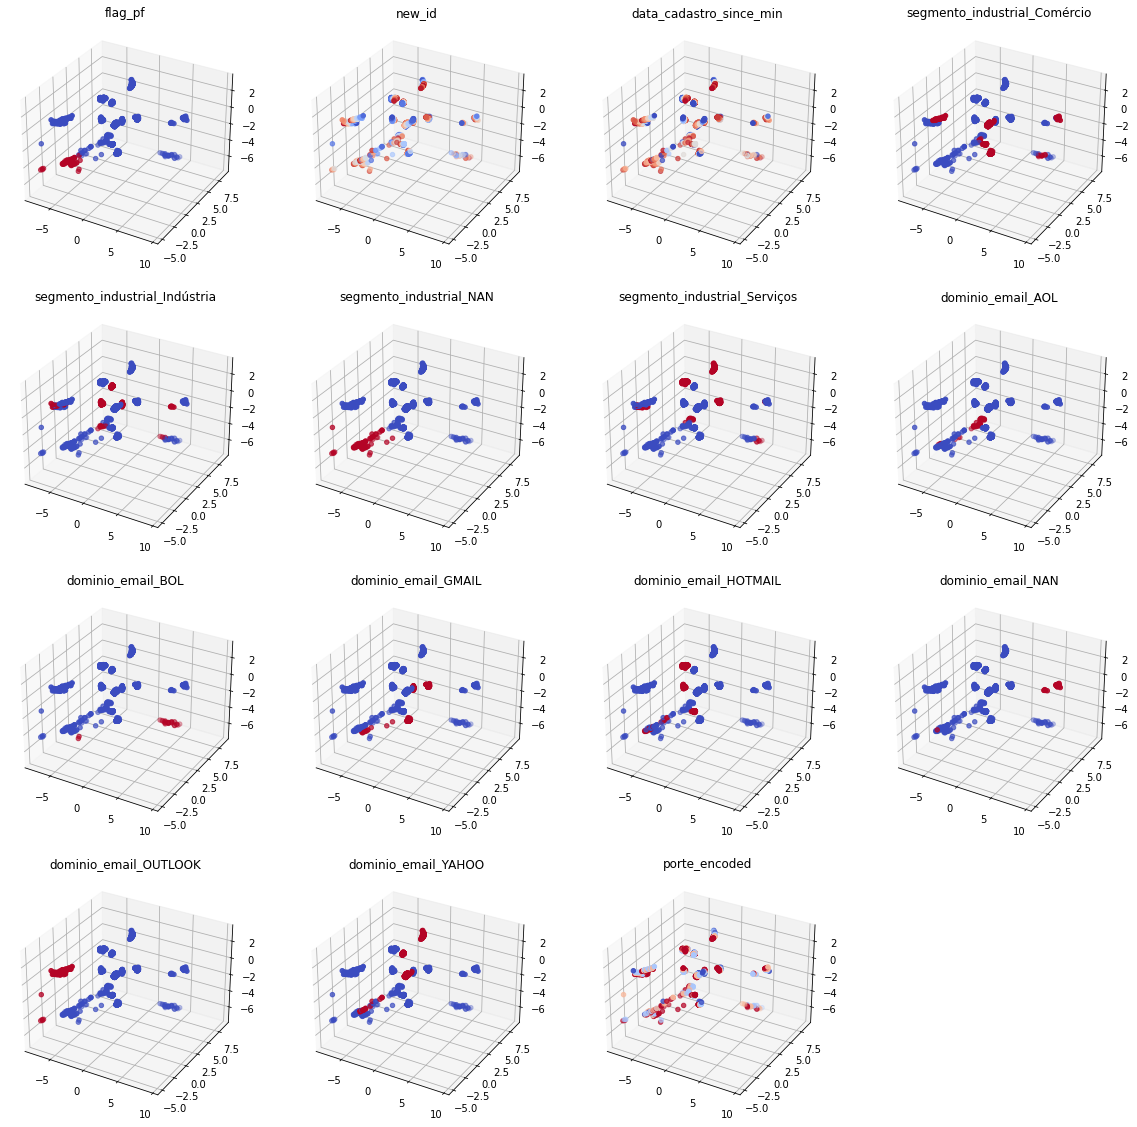

In [6]:
## visualização do cliente em 3 dimensões

# check uniqueness of each encoded representation
encoded_data_df = pd.DataFrame(encoded_data, columns=['encoded_1', 'encoded_2', 'encoded_3'])
if encoded_data_df.groupby(['encoded_1', 'encoded_2', 'encoded_3']).size().shape[0] / encoded_data_df.shape[0]:
    print('All encoded representations are unique.')
else:
    print('There are repeated encoded representations.')
    print(encoded_data_df
            .groupby(['encoded_1', 'encoded_2', 'encoded_3'])
            .size()
            .reset_index()
            .rename(columns={0:'count'})
            .sort_values(by='count', ascending=False))


# check if the encoded data is separable unsing 16 plots
fig = plt.figure(figsize=(20, 20))
for i, col in enumerate(base_cadastral_scaled.columns):
    ax = fig.add_subplot(4, 4, i+1, projection='3d')
    ax.scatter(encoded_data_df['encoded_1'], encoded_data_df['encoded_2'], encoded_data_df['encoded_3'], c=base_cadastral_scaled[col], cmap='coolwarm')
    plt.title(col)
plt.show()

In [7]:
print('Each encoded client and its id:')
encoded_data_df['id_cliente'] = base_cadastral['id_cliente']
encoded_data_df

Each encoded client and its id:


,encoded_1,encoded_2,encoded_3,id_cliente
0,-1.242136,-0.656581,1.150953,8437257970907722008
1,-3.357778,2.091061,1.588084,2179772649873197365
2,0.173178,-0.591141,3.045496,5692263270628375692
3,-3.359384,2.091272,1.587325,5611787644735474299
4,2.658748,-2.830933,2.241003,2020646654269061959
...,...,...,...,...
1310,1.077397,2.962455,-0.095141,7742008298942700792
1311,-0.287312,4.265274,2.713151,7720458526816091748
1312,2.256407,-2.798272,2.101217,2432667449154431819
1313,2.297354,-2.750021,2.260566,3183208564139585182


## Preparo para Modelagem
- junção dos dados e feature engineering.
- testagem de modelos de prateleira --> regressão logistica tem melhor resultado.
- modelo de deteção de anomalia

In [13]:
## Junção dos dados e feature engineering

# statisticaly significant data is lost in the followin merges
base_info_join = base_info_date.merge(encoded_data_df, on='id_cliente', how='inner')
base_join = base_info_join.merge(base_pagamentos_date, on=['id_cliente', 'safra_ref'], how='inner')
base_join_date_ordered = base_join.sort_values(by=['safra_ref'])

def encode_dates_given_ref(df, columns, ref):
    df_copy = df.copy()
    for col in columns:
        min_date = ref
        df_copy[col + '_since_min'] = (df_copy[col] - min_date).dt.days + 1
        df_copy[col + '_year'] = df_copy[col].dt.year
        df_copy[col + '_month'] = df_copy[col].dt.month
        df_copy[col + '_day'] = df_copy[col].dt.day
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

MIN_DATE = base_join_date_ordered['data_emissao_documento'].min()
base_join_date = encode_dates_given_ref(base_join_date_ordered, ['data_emissao_documento', 'data_vencimento'], MIN_DATE)

# feature engineering
base_join_date['renda_por_funcionario'] = base_join_date['renda_mes_anterior'] / base_join_date['no_funcionarios'].apply(lambda x: x if x > 0 else 1)
base_join_date['valor_a_pagar_por_renda'] = base_join_date['valor_a_pagar'] / base_join_date['renda_mes_anterior']
base_join_date['duracao_emprestimo'] = base_join_date['data_vencimento_since_min'] - base_join_date['data_emissao_documento_since_min']
# add number of loans late by client at the time of the loan / total number of loans taken by the client at the time of the loan
# add number of frauds by client at the time of the loan / total number of loans taken by the client at the time of the loan

X = base_join_date.drop(['id_cliente', 'safra_ref', 'data_pagamento', 'late_payment', 'fraud'], axis=1)
y = base_join_date['fraud']

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)


In [14]:
## testagem de modelos de prateleira --> regressão logistica tem melhor resultado


from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Define a list of classifiers to be used
classifiers = [
    (LogisticRegression(class_weight='balanced'), {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'solver': ['lbfgs', 'liblinear']
    }),
    (DecisionTreeClassifier(class_weight='balanced'), {
        'criterion': ['gini', 'entropy'],
        'max_depth': (1, 50),
        'min_samples_split': (2, 10)
    }),
    (RandomForestClassifier(n_estimators=10, class_weight='balanced'), {
        'max_depth': (1, 50),
        'min_samples_split': (2, 10)
    }),
    (LinearSVC(class_weight='balanced', random_state=42), {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'loss': ['hinge', 'squared_hinge']
    })
]

# Define a function to train and evaluate the models
def train_eval_models(clfs, X_train, y_train, X_eval, y_eval, filename):
    accuracy, precision, recall, f1, roc_auc = [], [], [], [], []
    best_models = {}
    for i, (clf, params) in enumerate(clfs):
        clf_name = clf.__class__.__name__

        # Define the BayesSearchCV
        opt = BayesSearchCV(clf, params, n_iter=10, cv=3, n_jobs=-1) # change n_iter to 50 does not improve the results significantly

        # Train the classifier
        opt.fit(X_train, y_train)
        
        # Make predictions on the eval set
        y_pred = opt.predict(X_eval)

        # Save the best model
        best_models[clf_name] = opt.best_estimator_
        
        # Calculate the metrics
        accuracy.append(accuracy_score(y_eval, y_pred))
        precision.append(precision_score(y_eval, y_pred))
        recall.append(recall_score(y_eval, y_pred))
        f1.append(f1_score(y_eval, y_pred))
        roc_auc.append(roc_auc_score(y_eval, y_pred))

        # Print the best parameters and the metrics
        print(f'Best parameters for {clf_name}: {opt.best_params_}')
        print(f'Accuracy: {accuracy[-1]:.2f}')
        print(f'Precision: {precision[-1]:.2f}')
        print(f'Recall: {recall[-1]:.2f}')
        print(f'F1: {f1[-1]:.2f}')
        print(f'ROC AUC: {roc_auc[-1]:.2f}')
        print('-----------------------------------------------------')

    return best_models

# Call the function
best_models = train_eval_models(classifiers, X_train, y_train, X_eval, y_eval, filename='results.txt')
best_models


Best parameters for LogisticRegression: OrderedDict([('C', 1.01169751787732), ('solver', 'lbfgs')])
Accuracy: 0.61
Precision: 0.09
Recall: 0.76
F1: 0.16
ROC AUC: 0.68
-----------------------------------------------------
Best parameters for DecisionTreeClassifier: OrderedDict([('criterion', 'entropy'), ('max_depth', 24), ('min_samples_split', 3)])
Accuracy: 0.92
Precision: 0.18
Recall: 0.19
F1: 0.19
ROC AUC: 0.57
-----------------------------------------------------
Best parameters for RandomForestClassifier: OrderedDict([('max_depth', 34), ('min_samples_split', 4)])
Accuracy: 0.95
Precision: 0.53
Recall: 0.03
F1: 0.05
ROC AUC: 0.51
-----------------------------------------------------


/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinea

Best parameters for LinearSVC: OrderedDict([('C', 1464.4780233033941), ('loss', 'squared_hinge')])
Accuracy: 0.94
Precision: 0.05
Recall: 0.01
F1: 0.02
ROC AUC: 0.50
-----------------------------------------------------


/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'LogisticRegression': LogisticRegression(C=1.01169751787732, class_weight='balanced'),
 'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=24, min_samples_split=3),
 'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', max_depth=34,
                        min_samples_split=4, n_estimators=10),
 'LinearSVC': LinearSVC(C=1464.4780233033941, class_weight='balanced', random_state=42)}

In [16]:
from sklearn.ensemble import IsolationForest
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

class IsolationForestWrapper(BaseEstimator):
    def __init__(self, n_estimators=10, max_samples='auto', contamination=0.1):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.contamination = contamination
        self.model = IsolationForest(n_estimators=self.n_estimators, 
                                     max_samples=self.max_samples, 
                                     contamination=self.contamination)
        self.y_train = None

    def fit(self, X, y=None):
        self.y_train = (y == 1).astype(int) if y is not None else None
        self.model.fit(X)
        return self

    def predict(self, X):
        pred = self.model.predict(X)
        return (pred == 1).astype(int)

    def score(self, X, y=None):
        if y is not None:
            y = (y == 1).astype(int)
            y_pred = self.predict(X)
            return f1_score(y, y_pred)
        elif self.y_train is not None:
            y_pred = self.predict(X)
            return f1_score(self.y_train, y_pred)
        else:
            raise ValueError("No y values were given during fitting, cannot calculate score.")

    def set_params(self, **params):
        super().set_params(**params)
        self.model.set_params(**params)
        return self

iso_forest = IsolationForestWrapper(n_estimators=30)

params = {
    'contamination': np.linspace(0.01, 0.2, 20)
}

opt = BayesSearchCV(iso_forest, params, n_iter=25, cv=3, n_jobs=-1)

opt.fit(X_train, y_train)

y_pred = opt.predict(X_eval)

print(confusion_matrix(y_eval, y_pred))

accuracy = accuracy_score(y_eval, y_pred)
precision = precision_score(y_eval, y_pred)
recall = recall_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred)
roc_auc = roc_auc_score(y_eval, y_pred)

# Print the best parameters and the metrics
print(f"Best parameters for IsolationForest: {opt.best_params_}")
print(f"Classifier: IsolationForest")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print('-----------------------------------------------------')


/home/vfranco-/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[[  902 13070]
 [   91   633]]
Best parameters for IsolationForest: OrderedDict([('contamination', 0.01)])
Classifier: IsolationForest


IndexError: invalid index to scalar variable.

## Model Training I

In [18]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.metrics import AUC, Precision, Recall
from tensorflow.keras.losses import BinaryFocalCrossentropy


# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

histories = []
params_list = []


Epoch 1/40
115/115 [==============================] - 17s 72ms/step - loss: 0.6004 - auc_1: 0.7100 - precision_1: 0.1538 - recall_1: 0.4194 - val_loss: 0.2085 - val_auc_1: 0.7542 - val_precision_1: 0.5000 - val_recall_1: 0.0235
Epoch 2/40
115/115 [==============================] - 6s 48ms/step - loss: 0.4616 - auc_1: 0.8076 - precision_1: 0.3318 - recall_1: 0.4076 - val_loss: 0.1928 - val_auc_1: 0.7725 - val_precision_1: 0.4174 - val_recall_1: 0.1257
Epoch 3/40
115/115 [==============================] - 6s 51ms/step - loss: 0.4317 - auc_1: 0.8388 - precision_1: 0.3557 - recall_1: 0.4452 - val_loss: 0.2307 - val_auc_1: 0.7773 - val_precision_1: 0.2969 - val_recall_1: 0.2818
Epoch 4/40
115/115 [==============================] - 6s 48ms/step - loss: 0.4095 - auc_1: 0.8573 - precision_1: 0.3736 - recall_1: 0.4923 - val_loss: 0.2691 - val_auc_1: 0.7771 - val_precision_1: 0.2540 - val_recall_1: 0.3936
Epoch 5/40
115/115 [==============================] - 6s 49ms/step - loss: 0.3964 - auc_1: 

In [23]:


def create_layers(input_layer, units, activation='relu', dropout_rate=0.1):
    x_dense = Dense(units, activation=activation)(input_layer)
    x_bn = BatchNormalization()(x_dense)
    x_drop = Dropout(dropout_rate)(x_bn)
    return [x_dense, x_bn, x_drop]

def fraud_detection_model(input_dim, units=15, learning_rate=0.001, weight_decay=0.0001, loss_function='binary_crossentropy'):
    input_layer = Input(shape=(input_dim, ))

    # encoder
    X = create_layers(input_layer, units)
    X_skip = create_layers(X[2], units)
    X = create_layers(X_skip[2] + X[1], units)
    X_skip = create_layers(X[2], units)
    X = create_layers(X_skip[2] + X[1], units)
    X = create_layers(X[2], units)
    X = Dense(1, activation='sigmoid')(X[2])

    model = Model(inputs=input_layer, outputs=X)

    adam = Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=adam, loss=loss_function, metrics=[AUC(), Precision(), Recall()])

    return model

input_dim = X_train.shape[1]

# use bayes optimization to find the best combination of lr, wd, class_weight, and loss function
params = {
    'units': 90,
    'lr': 0.002,
    'wd': 0.0003,
    'lf': 'binary_crossentropy',
    'cw': {0:1, 1:4}
}

model = fraud_detection_model(input_dim=input_dim, units=params['units'], learning_rate=params['lr'], weight_decay=params['wd'], loss_function=params['lf'])
history = model.fit(X_train, y, epochs=40, batch_size=512, validation_split=0.2, class_weight=params['cw'])

y_pred = model.predict(X_eval)


Epoch 1/40
115/115 [==============================] - 14s 65ms/step - loss: 0.6310 - auc_3: 0.6698 - precision_3: 0.1243 - recall_3: 0.3448 - val_loss: 0.2250 - val_auc_3: 0.7333 - val_precision_3: 0.7500 - val_recall_3: 0.0083
Epoch 2/40
115/115 [==============================] - 5s 45ms/step - loss: 0.4810 - auc_3: 0.7918 - precision_3: 0.3042 - recall_3: 0.3643 - val_loss: 0.2126 - val_auc_3: 0.7759 - val_precision_3: 0.3755 - val_recall_3: 0.1312
Epoch 3/40
115/115 [==============================] - 6s 48ms/step - loss: 0.4466 - auc_3: 0.8259 - precision_3: 0.3415 - recall_3: 0.3996 - val_loss: 0.2194 - val_auc_3: 0.7900 - val_precision_3: 0.3019 - val_recall_3: 0.2472
Epoch 4/40
115/115 [==============================] - 5s 42ms/step - loss: 0.4271 - auc_3: 0.8434 - precision_3: 0.3569 - recall_3: 0.4466 - val_loss: 0.2208 - val_auc_3: 0.7978 - val_precision_3: 0.3483 - val_recall_3: 0.2569
Epoch 5/40
115/115 [==============================] - 6s 48ms/step - loss: 0.4130 - auc_3: 

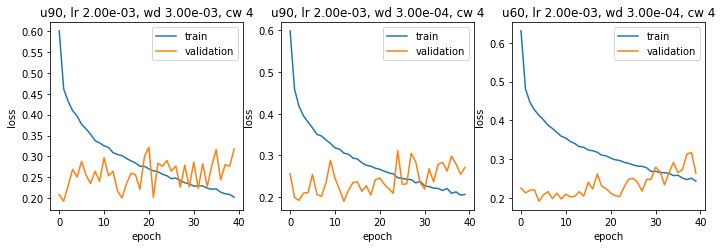

In [24]:
histories.append(history)
params_list.append(params)

# plot losses
fig = plt.figure(figsize=(20, 20))
for i, history in enumerate(histories):
    ax = fig.add_subplot(5, 5, i+1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    title = f'u{ params_list[i]["units"]}, lr {params_list[i]["lr"]:.2e}, wd {params_list[i]["wd"]:.2e}, cw {params_list[i]["cw"][1]}'
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
plt.show()

# model.summary()

## Prediction

In [22]:

## Junção dos dados e feature engineering

# statisticaly significant data is lost in the followin merges
base_info_join = base_info_date.merge(encoded_data_df, on='id_cliente', how='inner')
base_join_test = base_info_join.merge(base_pagamentos_teste_date, on=['id_cliente', 'safra_ref'], how='inner')
base_join_test_date_ordered = base_join_test.sort_values(by=['safra_ref'])

base_join_date_test = encode_dates_given_ref(base_join_test_date_ordered, ['data_emissao_documento', 'data_vencimento'], MIN_DATE)

# feature engineering
base_join_date_test['renda_por_funcionario'] = base_join_date_test['renda_mes_anterior'] / base_join_date_test['no_funcionarios'].apply(lambda x: x if x > 0 else 1)
base_join_date_test['valor_a_pagar_por_renda'] = base_join_date_test['valor_a_pagar'] / base_join_date_test['renda_mes_anterior']
base_join_date_test['duracao_emprestimo'] = base_join_date_test['data_vencimento_since_min'] - base_join_date_test['data_emissao_documento_since_min']

X_test = base_join_date_test.drop(['id_cliente', 'safra_ref'], axis=1)

# scale the data
X_test = scaler.transform(X_test)

y_pred = model.predict(X_test)

y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['INADIMPLENTE']
data_and_pred = pd.concat([base_join_date_test, y_pred], axis=1)

final = data_and_pred[['id_cliente', 'safra_ref', 'INADIMPLENTE']]
final.columns = final.columns.str.upper()
final

370/370 [==============================] - 3s 7ms/step


,ID_CLIENTE,SAFRA_REF,INADIMPLENTE
0,1661240395903230676,2021-07-01,0.005245
4660,1953058402621337677,2021-07-01,0.004949
4661,1953058402621337677,2021-07-01,0.007301
4662,1953058402621337677,2021-07-01,0.000971
4663,1953058402621337677,2021-07-01,0.005262
...,...,...,...
6905,696014079855281037,2021-11-01,0.020371
6906,696014079855281037,2021-11-01,0.443399
6907,696014079855281037,2021-11-01,0.010315
6845,2900002014851776114,2021-11-01,0.051831
